# Analyze features for software compilability predictions

In [1]:
import psycopg2
import pandas as pd

These SQL commands will query commit pairs, consisting of break commit and child commit, and their information as follows;
* break commit date
* child commit date
* break commit message
* child commit message
* break csha
* parent csha
* child csha
* break commit email
* child commit email

The first query is for uncompilable pairs, while the second query is for compilable pairs.


In [2]:
sql_nc = '''
select cs.cwhen as breaker
    , cm.cwhen as child
    , cs.message as breaker
    , cm.message as child
    , Substring(cs.csha,0,8) as broken
    , Substring(parent.prev,0,8) as parent 
    , Substring(child.curr,0,8) as child
    , cs.email as breaker
    , cm.email as child
from
impact_pairs as parent
, impact_pairs as child
, commits as cs
, commits as cm
,(
    (select prev as csha from impact_pairs) 
    union 
    (select curr as csha from impact_pairs)
) as ip
,(
    select cs.application as app
    , min(cwhen) as minwhen
    , max(cwhen) as maxwhen
    from 
    (
        (select prev as csha from impact_pairs) 
        union 
        (select curr as csha from impact_pairs)
    )
    as ip
    ,commits as cs
    ,(
        (select application,csha from findbugs_summary_uni) 
        union 
        (select application,csha from pmd_uni) 
        union 
        (select application,csha from sonarqube_system_uni) 
    )
    as anal
    where cs.csha=anal.csha
    and cs.csha=ip.csha
    and cs.application=anal.application
    and cs.application like %s
    group by cs.application
) as recovered
where
    cs.application = recovered.app
    and cs.cwhen <= recovered.maxwhen
    and cs.cwhen >= recovered.minwhen
    and cs.csha=ip.csha
    and parent.curr=cs.csha
    and child.prev=cs.csha
    and cm.csha=child.curr
    and ip.csha not in
    (
        select cs.csha
        from 
        (
            (select prev as csha from impact_pairs) 
            union 
            (select curr as csha from impact_pairs)
        )
        as ip
        ,commits as cs
        ,(
            (select application,csha from findbugs_summary_uni) 
            union 
            (select application,csha from pmd_uni) 
            union 
            (select application,csha from sonarqube_system_uni) 
        )
        as anal
        where cs.csha=anal.csha
        and cs.csha=ip.csha
        and cs.application=anal.application
    )
order by cs.application asc ,  cs.cwhen desc
'''

sql_c = '''
select cs.cwhen as breaker
    , cm.cwhen as child
    , cs.message as breaker
    , cm.message as child
    , Substring(cs.csha,0,8) as broken
    , Substring(parent.prev,0,8) as parent 
    , Substring(child.curr,0,8) as child
    , cs.email as breaker
    , cm.email as child
from
impact_pairs as parent
, impact_pairs as child
, commits as cs
, commits as cm
,(
    (select prev as csha from impact_pairs) 
    union 
    (select curr as csha from impact_pairs)
) as ip
,(
    select cs.application as app
    , min(cwhen) as minwhen
    , max(cwhen) as maxwhen
    from 
    (
        (select prev as csha from impact_pairs) 
        union 
        (select curr as csha from impact_pairs)
    )
    as ip
    ,commits as cs
    ,(
        (select application,csha from findbugs_summary_uni) 
        union 
        (select application,csha from pmd_uni) 
        union 
        (select application,csha from sonarqube_system_uni) 
    )
    as anal
    where cs.csha=anal.csha
    and cs.csha=ip.csha
    and cs.application=anal.application
    and cs.application like %s
    group by cs.application
) as recovered
where
    cs.application = recovered.app
    and cs.cwhen <= recovered.maxwhen
    and cs.cwhen >= recovered.minwhen
    and cs.csha=ip.csha
    and parent.curr=cs.csha
    and child.prev=cs.csha
    and cm.csha=child.curr
    and ip.csha in
    (
        select cs.csha
        from 
        (
            (select prev as csha from impact_pairs) 
            union 
            (select curr as csha from impact_pairs)
        )
        as ip
        ,commits as cs
        ,(
            (select application,csha from findbugs_summary_uni) 
            union 
            (select application,csha from pmd_uni) 
            union 
            (select application,csha from sonarqube_system_uni) 
        )
        as anal
        where cs.csha=anal.csha
        and cs.csha=ip.csha
        and cs.application=anal.application
    )
order by cs.application asc ,  cs.cwhen desc
'''

try:
    conn =  psycopg2.connect("dbname='icsme2018_march30' user='postgres' password = admin host='localhost'")
except:
    print ("I am unable to connect to the database")  

cur = conn.cursor()

cur.execute(sql_nc, ('apache-%',))
pairs_nc = cur.fetchall()
cur.execute(sql_c, ('apache-%',))
pairs_c = cur.fetchall()



Sample of Compilable and Uncombilable Pairs

In [3]:
print("Uncompilable Pairs")
pd.DataFrame(pairs_nc, columns=['break commit date', 'child commit date', 'break commit message',
                                'child commit message', 'break csha', 'parent csha', 'child csha',
                                'break commit email', 'child commit emil']).head()



Uncompilable Pairs


,break commit date,child commit date,break commit message,child commit message,break csha,parent csha,child csha,break commit email,child commit emil
0,2016-03-03 07:07:10,2016-03-07 21:23:34,"[CALCITE-1124] Add TIMESTAMPADD, TIMESTAMPDIFF...","Further to [CALCITE-1124], add implementation ...",0b9ea98,cf5d07b,4ac82a3,arina.yelchiyeva@gmail.com,jhyde@apache.org
1,2015-12-07 17:47:31,2015-12-07 19:06:26,Move code from JdbcImplementor and JdbcRules t...,Remove redundant code from RelToSqlConverter\n...,980d9f8,eedd3dc,47e0e7c,jhyde@apache.org,jhyde@apache.org
2,2015-11-20 16:03:21,2015-12-05 14:36:02,[CALCITE-968] Stream-to-relation and stream-to...,Fix up [CALCITE-968]\n,e9d5060,8281668,937fc46,milinda.pathirage@gmail.com,jhyde@apache.org
3,2015-10-06 13:55:24,2015-10-06 14:09:59,"[CALCITE-785] Add ""Piglet"", a subset of Pig La...",Fix Piglet DUMP applied to multisets and struc...,5cee2a1,82ac7b2,26f303e,jhyde@apache.org,jhyde@apache.org
4,2015-07-09 11:46:58,2015-07-09 15:36:03,[CALCITE-783] Infer collation of Project using...,Complete [CALCITE-783] by fixing some planner ...,c711fed,f7ec3e8,9177063,milinda.pathirage@gmail.com,jhyde@apache.org


In [4]:
print("Compilable Pairs")
pd.DataFrame(pairs_c, columns=['break commit date', 'child commit date', 'break commit message',
                                'child commit message', 'break csha', 'parent csha', 'child csha',
                                'break commit email', 'child commit emil']).head()

Compilable Pairs


,break commit date,child commit date,break commit message,child commit message,break csha,parent csha,child csha,break commit email,child commit emil
0,2018-01-03 06:03:57,2016-11-10 14:07:39,AVRO-2122: Cannot validate schemas with recurs...,AVRO-1957: TimeConversions do not implement ge...,7f9cbca,673261c,027d196,brtm@users.noreply.github.com,sean.timm@teamaol.com
1,2017-12-23 04:24:52,2017-12-05 10:37:11,AVRO-2120: Fix NullPointerException thrown by ...,AVRO-2109: Reset buffers in case of IOExceptio...,a7a43da,a3e05be,673261c,nbasjes@bol.com,gabor@apache.org
2,2017-12-14 01:56:21,2017-12-23 04:24:52,AVRO-2117: Cleanup Java - Remove redundant typ...,AVRO-2120: Fix NullPointerException thrown by ...,a3e05be,2bbb996,a7a43da,nbasjes@bol.com,nbasjes@bol.com
3,2017-12-13 06:54:13,2017-12-14 01:56:21,AVRO-2117: Cleanup Java - Copyright block is r...,AVRO-2117: Cleanup Java - Remove redundant typ...,2bbb996,8bc4951,a3e05be,nbasjes@bol.com,nbasjes@bol.com
4,2017-12-13 06:48:24,2017-12-13 06:54:13,AVRO-2117: Cleanup Java - Explicit types repla...,AVRO-2117: Cleanup Java - Copyright block is r...,8bc4951,4b69cb2,2bbb996,nbasjes@bol.com,nbasjes@bol.com


We will do feature engieering. [This Paper](https://ieeexplore.ieee.org/document/8009930/) observes behaviors that can be used to classifiy uncompilable and compilable pairs. 
* In uncompilable pairs, commit message of break commit and child commit are look alike. It indicates that both commits focus on the same thing.
* In uncompilable pairs, the time difference between commit are shorter
* Some keywords are more prevalent in commit messages of uncompilable pairs than compilable pairs


### Commit message similarity
We implement jaccard similarity to calculate the similarity between message of child and break commit. 

In [5]:
#show example of commit message

for i,pair in enumerate(pairs_nc):
    print(i)
    print("break message : ", pair[2])
    print("child message : ", pair[3])
    print()
    if i == 10: break

0
break message :  [CALCITE-1124] Add TIMESTAMPADD, TIMESTAMPDIFF functions (Arina Ielchiieva)

Close apache/calcite#204

child message :  Further to [CALCITE-1124], add implementation of TIMESTAMPADD, TIMESTAMPDIFF


1
break message :  Move code from JdbcImplementor and JdbcRules to new class SqlImplementor

child message :  Remove redundant code from RelToSqlConverter

Change default of Context.ignoreCast to false, otherwise
JdbcTest.testVarcharEquals fails. Strip casts inside comparisons.

Use dispatcher rather visitor pattern.

JdbcRel.implement methods delegate to JdbcImplementor (using code
inherited from RelToSqlConverter).


2
break message :  [CALCITE-968] Stream-to-relation and stream-to-stream joins (Milinda Pathirage)

Rule to transform Delta(Scan(constant-table)) to Empty;
fix NullPointerException in PruneEmptyRules.

child message :  Fix up [CALCITE-968]


3
break message :  [CALCITE-785] Add "Piglet", a subset of Pig Latin on top of Calcite algebra

Includes a parser, DI

In [6]:
#show example of commit message

for i,pair in enumerate(pairs_c):
    print(i)
    print("break message : ", pair[2])
    print("child message : ", pair[3])
    print()
    if i == 10: break

0
break message :  AVRO-2122: Cannot validate schemas with recursive definitions

Track which symbols have been visited to avoid StackOverflowErrors
when validating schemas with recursive definitions

This closes #281

Signed-off-by: Nandor Kollar <nkollar@apache.org>

child message :  AVRO-1957: TimeConversions do not implement getRecommendedSchema()

This closes #154

Signed-off-by: Gabor Szadovszky <gabor@apache.org>
Signed-off-by: sacharya <suraj@apache.org>
Signed-off-by: Nandor Kollar <nkollar@apache.org>


1
break message :  AVRO-2120: Fix NullPointerException thrown by Schema.Parser#parse("")

child message :  AVRO-2109: Reset buffers in case of IOException

Closes #260

Signed-off-by: Zoltan Ivanfi <zi@cloudera.com>
Signed-off-by: sacharya <suraj@apache.org>
Signed-off-by: Nandor Kollar <nkollar@apache.org>


2
break message :  AVRO-2117: Cleanup Java - Remove redundant type arguments

child message :  AVRO-2120: Fix NullPointerException thrown by Schema.Parser#parse("")


3
b

In [7]:
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

def jaccard(doc1, doc2,n):
    return 1- jaccard_distance(set(ngrams(doc1,n)), set(ngrams(doc2,n)))

In [8]:
import matplotlib.pyplot as plt

n_grams=2

#plot NC
plt.subplot(211)
jaccard_sim_nc = [jaccard(pair[2], pair[3], n_grams) for pair in pairs_nc]
n, bins, patches = plt.hist(jaccard_sim_nc, 100, density=True)
plt.xlabel('Similarity')
plt.ylabel('Uncompilable Pair')
plt.axis([0, 1, 0,6])
plt.grid(True)

#plot C
plt.subplot(212)
jaccard_sim_c = [jaccard(pair[2], pair[3], n_grams) for pair in pairs_c]
n, bins, patches = plt.hist(jaccard_sim_c, 100, density=True)
plt.xlabel('Similarity')
plt.ylabel('Compilable Pair')
plt.axis([0, 1, 0,6])
plt.grid(True)

plt.show()

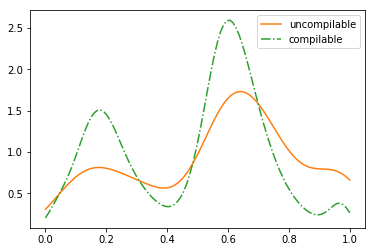

In [9]:
#estimate the probability density function

import scipy.stats as stats
import numpy as np
density_nc = stats.gaussian_kde(jaccard_sim_nc)
density_c = stats.gaussian_kde(jaccard_sim_c)
x = np.linspace(0,1,100)

plt.plot(x, density_nc(x),'C1', label='uncompilable', ls = '-')
plt.plot(x, density_c(x),'C2', label='compilable', ls = '-.')
plt.legend()

plt.show()

In [10]:
#show the commit message that look alike

for i, jaccard in enumerate(jaccard_sim_nc):
    if jaccard > 0.95:
        print(jaccard)
        print(pairs_nc[i][2])
        print(pairs_nc[i][3])
        print()

0.967479674796748
simplify

git-svn-id: https://svn.apache.org/repos/asf/commons/proper/bcel/trunk@1152074 13f79535-47bb-0310-9956-ffa450edef68

simplify

git-svn-id: https://svn.apache.org/repos/asf/commons/proper/bcel/trunk@1152075 13f79535-47bb-0310-9956-ffa450edef68


0.9834710743801653
Refactor trie package: reduce interface by extending IterableSortedMap and only adding prefixMap method, remove all key analyzers but the StringKeyAnalyzer, refactor PatriciaTrie class by moving all remaining methods to AbstractPatriciaTrie and fixing the key type to String, integrating the test classes into the framework.

git-svn-id: https://svn.apache.org/repos/asf/commons/proper/collections/trunk@1492866 13f79535-47bb-0310-9956-ffa450edef68

Refactor trie package: reduce interface by extending IterableSortedMap and only adding prefixMap method, remove all key analyzers but the StringKeyAnalyzer, refactor PatriciaTrie class by moving all remaining methods to AbstractPatriciaTrie and fixing the ke

### Break commit message and pair commit message share similar issue number

The message that look alike focus on the same issue. The break commit message and child commit message will share a similar issue number (e.g. JEXL-122). We will determine in what extend that uncompilable pairs share the same issue number, compare to compilable pairs

In [11]:
import re

def a_in_b(a,b):
    if len(a) == 0 or len(b) == 0:return False
    return any(x in a for x in b)

def all_a_in_b(a,b):
    if len(a) == 0 or len(b) == 0:return False
    return a == b

#uncompilable
child_msg_nc = [re.findall('[A-Za-z]+[- ]\d+', pair[3]) for pair in pairs_nc]
break_msg_nc = [re.findall('[A-Za-z]+[- ]\d+', pair[2]) for pair in pairs_nc]

matched_nc = [all_a_in_b(c,b) for c,b in zip(child_msg_nc,break_msg_nc) ]
print("contain_issue_number (nc) = ", sum(matched_nc)/len(pairs_nc))

#compilable
child_msg_c = [re.findall('[A-Za-z]+[- ]\d+', pair[3]) for pair in pairs_c]
break_msg_c = [re.findall('[A-Za-z]+[- ]\d+', pair[2]) for pair in pairs_c]

matched_c = [all_a_in_b(c,b) for c,b in zip(child_msg_c,break_msg_c) if c and b]
print("contain_issue_number  (c) = ", sum(matched_c)/len(pairs_c))


contain_issue_number (nc) =  0.5530085959885387
contain_issue_number  (c) =  0.30942095588235297


### Keywords Analysis

We will find out which key words that contribute to the classfication. We will use two techniques.
* Logistic Regression - We will train the classifyer and analyze the model parameters to determine which words contribute more to the classfication
* Naive Bayes - We wil use the probabilty estimation to determine which words contribute more to the classfication

We will start with logistic regression

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

In [13]:
X1 = [pair[3] for pair in pairs_nc]
X0 = [pair[3] for pair in pairs_c]

Y1 = [1] * len(X1)
Y0 = [0] * len(X0)

X = X1+X0
Y = Y1+Y0

X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state = 0)
vect = CountVectorizer().fit(X_train)
X_train_vectorized = vect.transform(X_train)
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
predictions = model.predict_proba(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions[:,1]))

AUC:  0.7249937849533215


In [14]:
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] 
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n{}\n'.format(feature_names[sorted_coef_index[:20]],model.coef_[0][sorted_coef_index[:20]]))
print('Largest Coefs: \n{}\n{}\n'.format(feature_names[sorted_coef_index[:-21:-1]],model.coef_[0][sorted_coef_index[:-21:-1]]))


Smallest Coefs:
['javadoc' 'httpcomponents' 'ranger' 'codec' 'at' 'apache' 'qpidjms'
 'closes' 'checkstyle' 'shiro' 'avro' 'headers' 'pool' 'allow' 'override'
 'vfs' 'compress' 'exception' 'correct' 'don']
[-1.24369186 -1.18971118 -1.13735202 -1.12944776 -1.01238353 -1.00791994
 -0.97815207 -0.95327293 -0.95232429 -0.94300378 -0.9401097  -0.91413165
 -0.89828004 -0.88182507 -0.88035584 -0.87755687 -0.85119174 -0.84462743
 -0.79891371 -0.77586296]

Largest Coefs: 
['oops' 'compile' 'addendum' '3993' 'files' 'sendcommand' 'jakarta'
 'compilation' 'adapted' 'abstractserversession' '580' 'commit' 'combiner'
 'sign' 'j5' 'missed' 'missing' 'predicates' 'safety' 'allocator']
[1.83463271 1.77944503 1.63432253 1.50600434 1.45256497 1.3496678
 1.34255533 1.33992522 1.25188628 1.19144388 1.18827122 1.17703667
 1.16983154 1.15836943 1.10880814 1.10071222 1.09815717 1.08803459
 1.07638775 1.0557044 ]



Next we will perform the same analysis using Naive Bayes. 

In [15]:
#text preparation for nltk.NaiveBayesClassifier
from nltk import word_tokenize
commit_msg = []

for line in pairs_nc:
    comment = line[3].strip().replace('\n', ' ').replace('\r', ' ')
    commit_msg.append("NC " + comment)
    
for line in pairs_c:
    comment = line[3].strip().replace('\n', ' ').replace('\r', ' ')
    commit_msg.append("C " + comment)

train_set = []

for line in commit_msg:
    label = line.split(' ')[0]
    tokens = word_tokenize(line.split(' ')[1])
    for token in tokens:
        train_set.append(({'word':token.lower()},label))

#show sample of train set
train_set [0:5]

[({'word': 'further'}, 'NC'),
 ({'word': 'remove'}, 'NC'),
 ({'word': 'fix'}, 'NC'),
 ({'word': 'fix'}, 'NC'),
 ({'word': 'complete'}, 'NC')]

In [16]:
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_set)
classifier.show_most_informative_features(150)

Most Informative Features
                    word = 'javadoc'           C : NC     =     66.5 : 1.0
                    word = 'drill-4280'       NC : C      =     33.0 : 1.0
                    word = '['                 C : NC     =     19.8 : 1.0
                    word = ']'                 C : NC     =     19.8 : 1.0
                    word = '.'                 C : NC     =     15.0 : 1.0
                    word = 'fixed'             C : NC     =     12.2 : 1.0
                    word = 'make'              C : NC     =     11.8 : 1.0
                    word = 'opennlp-118'      NC : C      =     11.0 : 1.0
                    word = 'opennlp-580'      NC : C      =     11.0 : 1.0
                    word = 'drill-4134'       NC : C      =     11.0 : 1.0
                    word = 'drill-1950'       NC : C      =     11.0 : 1.0
                    word = 'missed'           NC : C      =     11.0 : 1.0
                    word = 'drill-2517'       NC : C      =     11.0 : 1.0

### Time difference between break and child commits

Analyze the time time different between break and child commits in log scale. The probability distribution of uncompilable pairs and compilable pairs are different.

In [17]:
import math
time_dif_c = [float((pair[1] - pair[0]).total_seconds())/3600.0 for pair in pairs_c]    
time_dif_nc = [float((pair[1] - pair[0]).total_seconds())/3600.0 for pair in pairs_nc]   

time_dif_c_log = [ math.log(td) if td > 1.0/12 else math.log(1.0/12) for td in time_dif_c ]
time_dif_nc_log = [ math.log(td) if td > 1.0/12 else math.log(1.0/12) for td in time_dif_nc ]

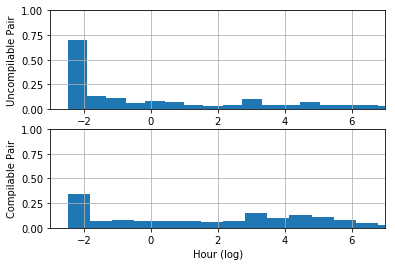

In [18]:
#plot NC
plt.subplot(211)

n, bins, patches = plt.hist(time_dif_nc_log, 20, density=True)
plt.xlabel('Hour (log)')
plt.ylabel('Uncompilable Pair')
plt.axis([-3, 7, 0,1])
plt.grid(True)

#plot C
plt.subplot(212)

n, bins, patches = plt.hist(time_dif_c_log, 20, density=True)
plt.xlabel('Hour (log)')
plt.ylabel('Compilable Pair')
plt.axis([-3, 7, 0,1])
plt.grid(True)

plt.show()

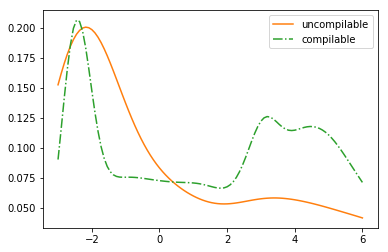

In [19]:
#convert to probability density function

density_t_nc = stats.gaussian_kde(time_dif_nc_log)
density_t_c = stats.gaussian_kde(time_dif_c_log)
x = np.linspace(-3,6,100)

plt.plot(x, density_t_nc(x),'C1', label='uncompilable', ls = '-')
plt.plot(x, density_t_c(x),'C2', label='compilable', ls = '-.')
plt.legend()

plt.show()